In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import random

import statsmodels.api as sm
from sklearn.model_selection import train_test_split

In [2]:
df1 = pd.read_csv('../data/processed_data/merged_characteristics.csv')
df2 = pd.read_csv('../data/processed_data/merged_characteristics_2017.csv')

#create mkt share data
blp_keys = ['market_ids', 'product_ids', 'firm_ids', 'shares', 'prices','demand_instruments0']

nonlinear_cols = ['csr_pay_94','EHBPercentTotalPremium']#,'SBCHavingDiabetesCopayment','SBCHavingaBabyCoinsurance']
#['act_value','csr_pay_94','csr_pay_87','SBCHavingDiabetesCopayment','SBCHavingaBabyCoinsurance']

linear_cols = [ 'act_value','MetalLevel_Platinum', 'MetalLevel_Silver']
#['CompositeRatingOffered_No','MetalLevel_Silver','MetalLevel_Platinum',
# 'BeginPrimaryCareCostSharingAfterNumberOfVisits' , 'csr_tot', 'csr_tot_94', 'PlanType_Indemnity']            
#'CSRVariationTypeBinary','DentalOnlyPlan_No','CompositeRatingOffered_No',

firm_cols =  linear_cols+ nonlinear_cols    
mkt_cols = [ 'DP05_0015PE' ,'DP05_0069PE','S1701_C01_017E'] #'DP03_0001PE'

keys = ['HIOS ID', 'IssuerId', 'County', 'State', 'FIPS County Code', 'Policy County FIPS Code','County Name']

def create_blp_data(df):
    
    #create market data...
    df['shares'] = df['Ever Enrolled Count']/df['DP03_0095E']

    #add blp columns
    df['prices'] = df['PREMI27']
    df['product_ids'] = df['IssuerId'].astype(str) +  df['County'].astype(str) 
    df['market_ids'] = df['County']
    df['firm_ids'] = df['IssuerId']

    #demand_instrument0
    MktIds = np.array(pd.get_dummies(df['IssuerId']))
    MktIds2 = (MktIds.T).dot(MktIds)
    dummies_proj = MktIds.dot( np.linalg.inv( MktIds2 ) ).dot( MktIds.T )
    df['demand_instruments0'] = dummies_proj.dot(df['prices']) #average price across markets


    #fix problematic columns =
    df = df.rename(columns={'Average Monthly Advanced CSR Payment for Consumers with 94%':'csr_pay_94',
                      'Average Monthly Advanced CSR Payment for Consumers with 87%':'csr_pay_87',
                           'Total Number of Consumers':'csr_tot',
                            'Number of Consumers with CSR AV of 94%':'csr_tot_94'})

    #'DP05_0072PE', ,

    blp_data = df[blp_keys+linear_cols+nonlinear_cols+mkt_cols+['DP03_0095E']]


    #standardize the cols
    for col in firm_cols:
        #this line is causing a warning?
        blp_data[col] = blp_data[col]/blp_data[col].var()

    #zero shares are not okay?
    blp_data = blp_data[blp_data['shares']!=0]
    return blp_data,df
    
X_train,df1 = create_blp_data(df1)
X_test,df2 = create_blp_data(df2)
X_test  = X_test.fillna(0)

/tmp/ipykernel_46033/3897991338.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  blp_data[col] = blp_data[col]/blp_data[col].var()


In [3]:
#split into training and test

model = sm.Logit(X_train['shares'],
                 sm.add_constant(X_train[linear_cols+nonlinear_cols+mkt_cols+['prices']]))
model_fit = model.fit()
print(model_fit.summary())
pred_shares = model_fit.predict(
    sm.add_constant(X_test[linear_cols+nonlinear_cols+mkt_cols+['prices']]))

/home/erichschulman/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Optimization terminated successfully.
         Current function value: 0.016099
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                 shares   No. Observations:                 5350
Model:                          Logit   Df Residuals:                     5340
Method:                           MLE   Df Model:                            9
Date:                Tue, 26 Apr 2022   Pseudo R-squ.:                     inf
Time:                        16:47:42   Log-Likelihood:                -86.131
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -3.8381      2.045     -1.876      0.061      -7.847      

/home/erichschulman/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:3500: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.llf/self.llnull
/home/erichschulman/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


mse 33319482.284650996 r2 0.36710927531977366
total variation 52646501.18152065


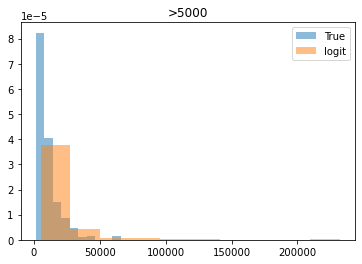

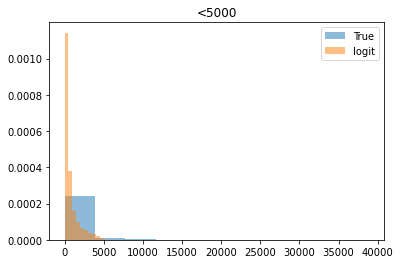

In [4]:
#evaluating model fit...
error = (X_test['shares']- pred_shares)*X_test['DP03_0095E']
true_shares = X_test['shares']*X_test['DP03_0095E']

mse  = float( (error**2).mean() ) 
r2 = float( 1 - (error**2).mean()/true_shares.var() )
print( 'mse',mse, 'r2', r2 )
print('total variation', true_shares.var())

blp_pred = pred_shares*X_test['DP03_0095E']
true_shares = X_test['shares']*X_test['DP03_0095E']

split = 5000
plt.title('>'+str(split))
plt.hist(blp_pred[true_shares >=split],label='True',alpha=.5,density=True)
plt.hist(true_shares[true_shares >=split],label='logit',alpha = .5,density=True)
plt.legend()
plt.show()


plt.title('<'+str(split))
plt.hist(blp_pred[true_shares <=split],label='True',alpha=.5,density=True)
plt.hist(true_shares[true_shares <=split],label='logit',alpha = .5,density=True)
plt.legend()
plt.show()

In [5]:
def report_error(X_test,pred_shares):
    pred_shares = np.array(pred_shares.copy())
    X_test = X_test.copy()
    X_test['error'] =  ((X_test['shares']- pred_shares)*X_test['DP03_0095E'])**2
    X_test['pred'] = pred_shares*X_test['DP03_0095E']
    result = X_test.merge(df2, how='inner',left_index=True, right_index=True,suffixes=('_x',''))    
    result = result.sort_values('error',ascending=False).head(50) 
    
    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count','prices','csr_tot']].mean()
    result_groupby = result.groupby('State')[['pred','Ever Enrolled Count']].mean()
    result_groupby[['pred_var','enroll_var']] = result.groupby('State')[['pred','Ever Enrolled Count']].std()
    result_groupby['count'] =result.groupby('State')['shares'].count()
    result_groupby = result_groupby.sort_values('pred',ascending=False)
    return result_groupby

print(report_error(X_test,pred_shares))

               pred  Ever Enrolled Count      pred_var    enroll_var  count
State                                                                      
IL     60723.718621         19015.000000           NaN           NaN      1
AZ     38294.322501         51542.000000    805.008799  71539.407266      2
MI     26504.563761          1962.142857   4843.082425   1329.678461      7
NV     26440.246499          2607.000000           NaN           NaN      1
FL     26240.013853         49260.125000   8740.984828  59332.042528     16
PA     19714.373579           270.000000           NaN           NaN      1
TX     18535.984400         57073.888889  13489.187073  34834.845153      9
VA     15438.945546         35581.000000           NaN           NaN      1
MO     13143.695503         33361.000000           NaN           NaN      1
NC     10543.244522         46566.333333   3272.359706  18071.783872      3
GA      9049.889037         36800.000000   1214.218231  13393.341368      3
OK      8755

# comparing market structure in the 2 years

       Ever Enrolled Count      prices  MetalLevel_Silver        csr_tot  \
State                                                                      
NE              178.666667  306.537000           0.333333     289.466667   
UT             3039.272727  287.319000           0.400000    2682.454545   
VA              894.500000  160.690435           0.347826     901.500000   
FL            84114.600000  261.304044           0.320000  130669.400000   
NC             2907.600000  316.941333           0.400000    2882.600000   
TX              130.666667  169.886111           0.333333     131.666667   
WI              994.000000   73.783333           0.527778    1271.333333   
MO              607.000000  256.775714           0.380952     670.000000   
MT              316.000000  274.047500           0.500000     377.000000   

       count  
State         
NE        15  
UT        11  
VA         6  
FL         5  
NC         5  
TX         3  
WI         3  
MO         1  
MT         1 

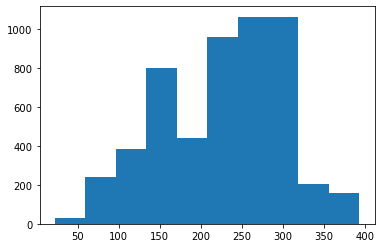

In [6]:
highest_shares = df1[['shares','IssuerId','State','County Name',
          'Ever Enrolled Count','DP03_0095E','act_value','prices','MetalLevel_Silver',
    'csr_tot','csr_pay_94']].sort_values('shares',ascending=False).head(50)


highest_share_groupy = highest_shares.groupby('State')[['Ever Enrolled Count','prices','MetalLevel_Silver','csr_tot']].mean()
highest_share_groupy['count'] =highest_shares.groupby('State')['shares'].count()
highest_share_groupy = highest_share_groupy.sort_values('count',ascending=False)
print(highest_share_groupy)

plt.hist(df1['prices'][df1['prices']>=.1])
plt.show()

       Ever Enrolled Count      prices  MetalLevel_Silver  csr_tot  count
State                                                                    
NC             3979.588235  332.437328           0.362834      0.0     17
FL            51536.666667  299.441730           0.371673      0.0      9
MT              167.666667  386.140857           0.309524      0.0      6
VA              894.666667  191.571136           0.363636      0.0      6
TX             1292.600000  253.378340           0.448583      0.0      5
WI             1223.666667  190.780896           0.429101      0.0      3
MO              486.000000  315.478421           0.526316      0.0      2
KS              244.000000  206.892857           0.428571      0.0      1
OR             1552.000000  289.800000           0.400000      0.0      1


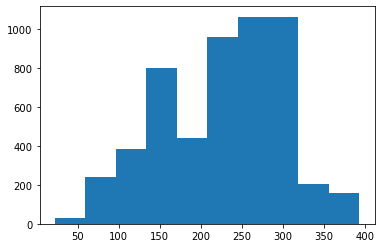

In [7]:
highest_shares = df2[['shares','IssuerId','State','County',
          'Ever Enrolled Count','DP03_0095E','act_value','prices','MetalLevel_Silver',
    'csr_tot','csr_pay_94']].sort_values('shares',ascending=False).head(50)


highest_share_groupy = highest_shares.groupby('State')[['Ever Enrolled Count','prices','MetalLevel_Silver','csr_tot']].mean()
highest_share_groupy['count'] =highest_shares.groupby('State')['shares'].count()
highest_share_groupy = highest_share_groupy.sort_values('count',ascending=False)
print(highest_share_groupy)

plt.hist(df1['prices'][df1['prices']>=.1])
plt.show()